<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 2 Assignment 2*

# Document Representations: Bag-Of-Words

In [2]:
import re
import string

!pip install -U nltk

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize # Sentence Tokenizer
from nltk.tokenize import word_tokenize # Word Tokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Requirement already up-to-date: nltk in /Applications/anaconda3/lib/python3.6/site-packages (3.4.4)


[nltk_data] Downloading package punkt to /Users/mattkirby/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mattkirby/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1) (optional) Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [3]:
import requests
import bs4
from bs4 import BeautifulSoup
import time

In [4]:
jobs = []
companies = []
locations = []
summaries = []

max_results_per_city = 100
city_set = ["Dallas"]
for city in city_set:
      for start in range(0, max_results_per_city, 10):
        page = requests.get("https://www.indeed.com/jobs?q=data+scientist&l=" + str(city) + "&start=" + str(start))
        time.sleep(1)                      
        soup = BeautifulSoup(page.text, "lxml") 
        # for each row
        for div in soup.find_all(name="div", attrs={"class":"row"}):
            # Job title
            for i in div.findAll(name="a", attrs={"data-tn-element":"jobTitle"}):
                job_title = i["title"]
                if len(job_title) > 0:
                    jobs.append(job_title)
                else:
                    jobs.append('not found')
            # Company    
            for i in div.findAll(name="span", attrs={"class":"company"}):
                company = i.text
                if len(company) > 0:
                    companies.append(company)
                else:
                    companies.append('not found')
            # Location    
            for i in div.findAll("div", attrs={"class": "recJobLoc"}):
                location = i['data-rc-loc']
                if len(location) > 0:
                    locations.append(location)
                else:
                    location.append('not found')
            # Summary  
            for i in div.findAll("div", attrs={"class": "summary"}):
                summary = i.text
                if len(summary) > 0:
                    summaries.append(summary)
                else:
                    summary.append('not found')

len(jobs), len(companies), len(locations), len(summaries)

(160, 160, 160, 160)

In [5]:
jobs = pd.DataFrame({'job_title':jobs,
          'company':companies,
          'location':locations,
          'summary':summaries})

In [6]:
def clean(df):
    df['company'] = df['company'].str.strip()
    df['summary'] = df['summary'].str.strip()
    df['state'] = df['location'].str[-2:]
    df['state'] = df['state'].where(df['state'] == 'TX')
    df = df.dropna(axis = 0)
    
clean(jobs)

In [7]:
jobs.head()

,job_title,company,location,summary,state
0,Data Scientist,Verizon,"Irving, TX",Work cross functionally with teams to develop ...,TX
1,Data Scientist/Statistician (Statistical Model...,S5 Stratos,"Dallas, TX","Tests new statistical analysis methods, softwa...",TX
2,Medicare Insurance Agent – Industry-best comp ...,ASSURANCE Independent Agents,"Dallas, TX",Progress-tracking and business-growing dashboa...,TX
3,Senior Data Scientist,Verizon,"Irving, TX","Knowledge of development, testing, infrastruct...",TX
4,Senior Data Scientist and Engineer,Verizon,"Irving, TX",Closely collaborate with cross-functional team...,TX


## 2) Use Spacy to tokenize / clean the listings 

In [8]:
import spacy
nlp = spacy.load("en_core_web_lg")

from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [9]:
jobs['tokens'] = jobs['summary'].apply(lambda x: tokenizer(x))

jobs['tokens'].head()

0    (Work, cross, functionally, with, teams, to, d...
1    (Tests, new, statistical, analysis, methods,, ...
2    (Progress-tracking, and, business-growing, das...
3    (Knowledge, of, development,, testing,, infras...
4    (Closely, collaborate, with, cross-functional,...
Name: tokens, dtype: object

# 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [10]:
stop_words = 'sixty, other, co, made, since, too, him, cannot, no, across, herein, during, anyone, his, can, describe, some, hundred, she, when, hereupon, of, latter, around, third, if, already, detail, well, thru, along, few, four, more, nine, ie, being, beforehand, seeming, with, meanwhile, thereupon, under, thereby, due, towards, empty, still, three, becomes, otherwise, less, it, among, never, that, system, thick, perhaps, amongst, them, besides, sometimes, while, nobody, the, us, on, whatever, moreover, they, should, whom, mill, own, everywhere, seem, where, are, former, sincere, also, give, he, twelve, a, our, very, bottom, etc, throughout, see, hasnt, everyone, sometime, two, even, therein, enough, fifteen, thus, ten, is, been, anywhere, hereby, whole, done, indeed, wherever, there, seemed, and, take, yet, put, although, all, would, could, about, themselves, get, myself, anyway, i, namely, became, their, nothing, because, itself, same, every, was, my, until, ourselves, in, as, through, inc, somewhere, your, these, onto, to, ltd, behind, one, per, amoungst, upon, full, con, whose, over, thereafter, wherein, between, here, hence, after, fifty, others, alone, couldnt, forty, part, afterwards, or, whereupon, then, interest, against, herself, seems, whenever, whither, whereafter, become, mine, find, anything, into, each, yourself, those, six, else, elsewhere, please, top, formerly, toward, its, eleven, serious, together, further, only, name, within, somehow, off, how, yourselves, himself, five, not, above, move, might, amount, whether, show, first, ever, me, re, anyhow, fill, something, this, we, either, though, but, always, another, which, what, go, any, whoever, un, were, except, therefore, without, cant, had, be, such, found, will, beside, out, much, yours, nevertheless, up, cry, an, before, nowhere, beyond, why, am, call, nor, down, however, least, many, side, eg, hers, none, front, via, fire, by, thin, often, you, must, rather, hereafter, thence, bill, has, back, most, once, than, both, eight, her, for, becoming, from, latterly, whereas, de, keep, several, everything, twenty, whereby, so, now, at, may, last, who, below, whence, noone, next, do, again, someone, almost, have, mostly, ours, neitherless, yours, put, before, find, can, others, whereby, due, during, someone, became, thence, to, under, thereupon, namely, other, either, anyhow, cannot, anything, bill, whereupon, nowhere, everything, therein, eg, nobody, take, since, seems, yourself, several, however, along, although, about, none, though, two, being, why, even, she, were, everyone, there, on, how, a, show, at, whole, i, was, within, full, eight, own, myself, wherever, everywhere, again, off, six, three, her, but, through, fifty, much, never, when, forty, has, been, otherwise, nor, throughout, nevertheless, please, hereby, if, me, thin, whose, very, whether, least, describe, side, noone, de, inc, see, herein, whither, themselves, out, ltd, beforehand, last, thereafter, those, besides, rather, it, not, most, amount, us, across, into, get, cry, as, so, neither, they, the, such, them, because, onto, back, whenever, our, had, part, con, here, then, wherein, your, should, beyond, without, else, no, call, also, am, whereafter, per, hundred, my, over, may, himself, twelve, latter, fifteen, made, each, third, above, herself, might, towards, serious, in, together, moreover, sometime, seemed, some, its, anywhere, his, many, fire, hers, must, move, after, top, thereby, do, whereas, amoungst, that, seem, of, latterly, yet, whoever, beside, mill, becomes, down, enough, ten, up, one, hereupon, ie, cant, elsewhere, give, almost, while, except, will, five, mostly, nothing, via, go, or, first, him, be, un, twenty, anyone, upon, only, thru, behind, between, could, their, these, any, have, with, every, hence, whatever, thus, becoming, often, few, another, etc, already, until, indeed, nine, whom, same, what, somehow, done, name, afterwards, from, former, now, where, we, mine, system, interest, among, re, still, thick, formerly, something, hereafter, sometimes, are, found, fill, further, too, keep, toward, he, than, around, you, all, eleven, itself, empty, which, front, this, co, bottom, an, become, yourselves, ours, therefore, for, both, hasnt, once, against, couldnt, more, somewhere, by, ourselves, would, amongst, anyway, sixty, sincere, detail, and, well, four, always, perhaps, seeming, alone, who, ever, below, next, whence, meanwhile, is'.split(', ')
STOPS = list(set(stop_words))

In [11]:
data = jobs['summary']

In [12]:
vectorizer = CountVectorizer(input='content', stop_words = STOPS)

vectorizer.fit(data)

vectorizer.vocabulary_

dtm = vectorizer.transform(data)

In [13]:
dtm = pd.DataFrame(dtm.todense(), columns = vectorizer.get_feature_names())

In [14]:
dtm.head()

,10,1b,215,51,ability,able,academic,acceptance,accomplished,accurate,...,word2vec,work,worker,working,workplace,world,wrangling,write,year,years
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 4) Visualize the most common word counts

In [15]:
word_counts = []
words = []

for column in dtm.columns:
    word_counts.append(dtm[column].value_counts()[0])
    words.append(column)

In [16]:
word_counts_df = pd.DataFrame({'word':words, 'does not appear in':word_counts})   
word_counts_df.head()

,word,does not appear in
0,10,153
1,1b,159
2,215,159
3,51,159
4,ability,159


In [17]:
word_counts_df['appears in'] = 160 - word_counts_df['does not appear in']
word_counts_df.head()

,word,does not appear in,appears in
0,10,153,7
1,1b,159,1
2,215,159,1
3,51,159,1
4,ability,159,1


In [18]:
word_counts_df = word_counts_df.sort_values(by = ['appears in'], ascending=False)
word_counts_df.head(20)

,word,does not appear in,appears in
147,data,53,107
339,machine,88,72
327,learning,88,72
220,experience,103,57
518,scientist,118,42
475,python,121,39
26,analytics,127,33
581,team,133,27
634,years,138,22
318,knowledge,139,21


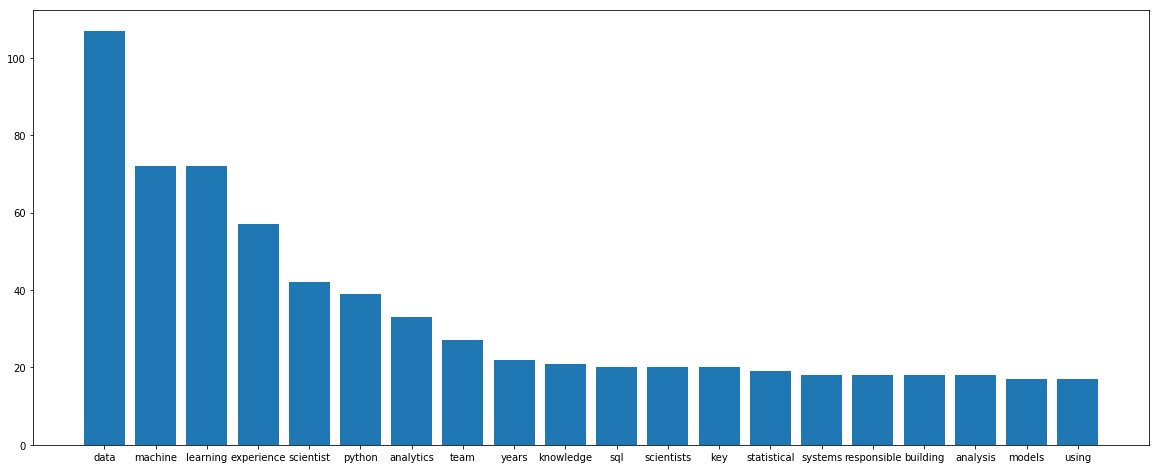

In [19]:
plot_df = word_counts_df.head(20)

plt.bar(plot_df['word'], plot_df['appears in'])
fig = plt.gcf()
fig.set_size_inches(20, 8)
plt.show();

 # 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features = 5000)

dtm = tfidf.fit_transform(data)

docs = pd.DataFrame(dtm.todense(), columns = tfidf.get_feature_names())

docs.head()

,10,1b,215,51,ability,able,academic,acceptance,accomplished,accurate,...,word2vec,work,worker,working,workplace,world,wrangling,write,year,years
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.240226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 # 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [21]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')

nn.fit(dtm.todense())

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [22]:
perfect_listing = ["""Money, high paying, high salary, money, money, money"""]

In [23]:
new = tfidf.transform(perfect_listing)

nn.kneighbors(new.todense())

(array([[1.21025467, 1.22008595, 1.22549059, 1.41421356, 1.41421356]]),
 array([[ 45,  41,  87,  82, 132]]))

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.